# 연산그래프 구조 변환, 배열 연산 테스트 [[참조](https://velog.io/@pre_f_86/series/PyTorch-AutoGrad%EB%9E%80-%EB%AC%B4%EC%97%87%EC%9D%B8%EA%B0%80)]

- Pytorch의 연산 로직에 대한 이해와 비슷하게 작동하도록 구현

- Param 객체 내의 Data가 숫자, 소수점 등의 Scalar 데이터 타입이 아닌 배열(Numpy) 객체를 활용하여 Matrix 데이터를 담을 수 있도록 구현

    - 숫자, 소수점을 담는 경우에는 너무 많은 객체가 생성되어 연산량, 메모리 사용량 등의 증가를 해결 하고자 함



In [10]:
import numpy as np
import torch
import src as my

In [11]:

val1 = my.Param(np.zeros((10)), requires_grad=True)
val2 = my.Param(np.ones((10)), requires_grad=True)

out = abs(-((val1*val2)*5**2/10-1))
summed = 0
for val in out:
    summed += val
summed.backward()
val1.grad, val2.grad

(array([-2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5]),
 array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.]))

In [3]:

val1 = torch.zeros((10), requires_grad=True)
val2 = torch.ones((10), requires_grad=True)

out = abs(-((val1*val2)*5**2/10-1))
summed = 0
for val in out:
    summed += val
summed.backward()
val1.grad, val2.grad

(tensor([-2.5000, -2.5000, -2.5000, -2.5000, -2.5000, -2.5000, -2.5000, -2.5000,
         -2.5000, -2.5000]),
 tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.]))

# 인덱싱(Get, Set) 그래디언트 테스트

- val1 : 연산 테스트, Leaf 노드까지 그래디언트가 잘 전달 되는지 확인

- val2 : val1과 동일

- val3 : Set 연산, Get 연산 테스트

- val4 : 중첩되는 Set 연산에 대한 테스트

In [6]:
import numpy as np
import src as my
import torch

In [7]:

def test(val1, val2, val3, val4):
    out1 = val1+5

    out2 = out1*val2

    out2[2:7] = val3[:5]

    out2[1:3] = val4

    out3 = 0
    for i in range(out2.data.shape[0]):
        out3 = (out3 + out2[i])*5
    out3.backward()
    print(val1.grad)
    print(val2.grad)
    print(val3.grad)
    print(val4.grad)

In [8]:
val1 = my.Param(np.zeros(10), requires_grad=True)
val2 = my.Param(np.ones(10), requires_grad=True)
val3 = my.Param(np.ones(10), requires_grad=True)
val4 = my.Param(np.ones(2), requires_grad=True)

test(val1, val2, val3, val4)

[9.765625e+06 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 1.250000e+02 2.500000e+01 5.000000e+00]
[4.8828125e+07 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 6.2500000e+02 1.2500000e+02 2.5000000e+01]
[    0. 78125. 15625.  3125.   625.     0.     0.     0.     0.     0.]
[1953125.  390625.]


In [9]:

val1 = torch.zeros(10, requires_grad=True)
val2 = torch.ones(10, requires_grad=True)
val3 = torch.ones(10, requires_grad=True)
val4 = torch.ones(2, requires_grad=True)

test(val1, val2, val3, val4)

tensor([9.7656e+06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.2500e+02, 2.5000e+01, 5.0000e+00])
tensor([4.8828e+07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 6.2500e+02, 1.2500e+02, 2.5000e+01])
tensor([    0., 78125., 15625.,  3125.,   625.,     0.,     0.,     0.,     0.,
            0.])
tensor([1953125.,  390625.])


# 레이어 연산 테스트

※ 브로드캐스팅으로 인해 역전파된 그래디언트의 차원이 맞지 않는 현상 발견 (Layer의 Bias 부분)

- Linear 연산 이후 계산된 그래디언트 비교

In [ ]:
import numpy as np
import src as my
import torch
import torch.nn as nn


In [ ]:

class mymodel(my.layers.Module):
    def __init__(self):
        self.l1 = my.layers.Linear(2,4,bias=True)
        self.l2 = my.layers.Linear(4,4,bias=True)
        self.l3 = my.layers.Linear(4,4,bias=True)
        self.l4 = my.layers.Linear(4,1,bias=True)

    def forward(self,x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out = self.l4(out)
        ret = 0

        for o in out:
            ret = ret + o
        return ret
model = mymodel()
x = my.Param(np.ones((5,2)))

out = model(x)
out.backward()


In [ ]:
import numpy as np
import src as my
model = mymodel()
x = my.Param(np.ones((5,2)))

out = model(x)
out.backward()

print()
print(out,out.shape)
print(model.l1.weight.grad)
print(model.l1.bias.grad)
print(model.l2.weight.grad)
print(model.l2.bias.grad)
print(model.l3.weight.grad)
print(model.l3.bias.grad)
print(model.l4.weight.grad)
print(model.l4.bias.grad)



Node (Data:[1065.], requrired_grad:True) (1,)
[[80. 80. 80. 80.]
 [80. 80. 80. 80.]]
[[16. 16. 16. 16.]
 [16. 16. 16. 16.]
 [16. 16. 16. 16.]
 [16. 16. 16. 16.]
 [16. 16. 16. 16.]]
[[60. 60. 60. 60.]
 [60. 60. 60. 60.]
 [60. 60. 60. 60.]
 [60. 60. 60. 60.]]
[[4. 4. 4. 4.]
 [4. 4. 4. 4.]
 [4. 4. 4. 4.]
 [4. 4. 4. 4.]
 [4. 4. 4. 4.]]
[[65. 65. 65. 65.]
 [65. 65. 65. 65.]
 [65. 65. 65. 65.]
 [65. 65. 65. 65.]]
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[[265.]
 [265.]
 [265.]
 [265.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [ ]:

class mymodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2,4, bias=True)
        self.l2 = nn.Linear(4,4, bias=True)
        self.l3 = nn.Linear(4,4, bias=True)
        self.l4 = nn.Linear(4,1, bias=True)
    
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.children():
            if isinstance(layer, nn.Linear):
                nn.init.constant_(layer.weight, 1)  
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 1) 

    def forward(self,x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out = self.l4(out)
        ret = 0
        for o in out:
            ret = ret + o
        return ret
    

model = mymodel()
x = torch.ones((5,2))
out = model(x)
out.backward()
out

tensor([1065.], grad_fn=<AddBackward0>)

In [ ]:
print(model.l1.weight.grad)
print(model.l1.bias.grad)
print(model.l2.weight.grad)
print(model.l2.bias.grad)
print(model.l3.weight.grad)
print(model.l3.bias.grad)
print(model.l4.weight.grad)
print(model.l4.bias.grad)

tensor([[80., 80.],
        [80., 80.],
        [80., 80.],
        [80., 80.]])
tensor([80., 80., 80., 80.])
tensor([[60., 60., 60., 60.],
        [60., 60., 60., 60.],
        [60., 60., 60., 60.],
        [60., 60., 60., 60.]])
tensor([20., 20., 20., 20.])
tensor([[65., 65., 65., 65.],
        [65., 65., 65., 65.],
        [65., 65., 65., 65.],
        [65., 65., 65., 65.]])
tensor([5., 5., 5., 5.])
tensor([[265., 265., 265., 265.]])
tensor([5.])


# 서로 다른 차원을 가진 객체에 대한 역전파 테스트 [[참조](https://numpy.org/doc/stable/user/basics.broadcasting.html)]

- (5, 1) 과 (1)의 차원을 가진 두 객체 사이의 연산

- (5, 1) 과 (1, 5)의 차원을 가진 두 객체 사이의 연산

**Numpy 브로드캐스팅 규칙**

1. 두 차원의 길이가 맞지 않는 경우 길이가 맞을 때까지 작은 차원의 앞에 1을 붙임

    - (5, 2, 5) + (5,) -> (5, 2, 5) + (1, 1, 5)

2. 차원이 1인 경우 각 위치에 맞는 차원만큼 배열 복사

    - (5, 2, 5) + (1, 1, 5) -> (5, 2, 5) + (5, 2, 5)

In [ ]:
import src as my
import numpy as np

In [ ]:
tmp1 = my.Param(np.zeros((1, 5)), requires_grad=True)
tmp2 = my.Param(np.ones((5, 1)), requires_grad=True)
out = tmp1*tmp2
out.backward()

In [ ]:
tmp1.grad, tmp1.grad.shape, tmp2.grad, tmp2.grad.shape

(array([[5., 5., 5., 5., 5.]]),
 (1, 5),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]),
 (5, 1))

# 학습 테스트

- 가중치를 1이 아닌 He Init을 사용하여 초기화

- Adam 구현

- ReLU 구현

In [ ]:
import src as my
import numpy as np

In [ ]:
def relu(x):
    x[x<0] = 0
    return x

class mymodel(my.layers.Module):
    def __init__(self):
        self.l1 = my.layers.Linear(2,16,bias=True)
        self.l2 = my.layers.Linear(16,16,bias=True)
        self.l3 = my.layers.Linear(16,16,bias=True)
        self.l4 = my.layers.Linear(16,1,bias=True)

    def forward(self,x):
        out = self.l1(x)
        out = relu(out)
        out = self.l2(out)
        out = relu(out)
        out = self.l3(out)
        out = relu(out)
        out = self.l4(out)
        return out

x = my.Param(np.stack([np.arange(100), np.arange(100)], 1))/100
y = my.Param(np.arange(100).reshape(-1, 1))/100

In [ ]:

model = mymodel()
optim = my.optimizers.Adam(params=model.parameters(),lr=1e-3)
for i in range(1000):
    out = model(x)
    
    loss = (out-y)**2

    loss_mean = 0
    for l in loss:
        loss_mean = loss_mean + l/100

    
    loss_mean.backward()
    optim.update()
    optim.zero_grad()
    if (i%10==0):
        print(loss_mean)  
model([1000,1000])

Data:[0.18300367], requrired_grad:True
Data:[0.04558312], requrired_grad:True
Data:[0.00253195], requrired_grad:True
Data:[2.43981414e-06], requrired_grad:True
Data:[0.00052742], requrired_grad:True
Data:[0.00049233], requrired_grad:True
Data:[0.00027985], requrired_grad:True
Data:[0.0001116], requrired_grad:True
Data:[3.78963245e-05], requrired_grad:True
Data:[1.0044037e-05], requrired_grad:True
Data:[1.74961075e-06], requrired_grad:True
Data:[7.58300889e-08], requrired_grad:True
Data:[3.37215609e-08], requrired_grad:True
Data:[8.47882185e-08], requrired_grad:True
Data:[6.00794388e-08], requrired_grad:True
Data:[2.55156315e-08], requrired_grad:True
Data:[7.84502031e-09], requrired_grad:True
Data:[1.72523721e-09], requrired_grad:True
Data:[2.06079571e-10], requrired_grad:True
Data:[1.89906463e-11], requrired_grad:True
Data:[4.19445674e-11], requrired_grad:True
Data:[3.81100717e-11], requrired_grad:True
Data:[1.73545469e-11], requrired_grad:True
Data:[4.54230245e-12], requrired_grad:Tru

Data:[1000.], requrired_grad:True

# 주요 배열 연산 테스트

※ 이 과정에서 Param 객체 생성시 Numpy 스칼라인 경우에는 허용되지 않는 경우(버그) 수정

- Sum(), Mean() 연산 : 그래디언트 테스트, 연산 결과 테스트

- Reshape, Stack, Concat 연산 : 그래디언트 테스트, 연산 결과 테스트

- aranage, ones, zeros, full, ~_like 연산 : 결과 테스트

In [ ]:
import src as my
import numpy as np
import torch
import torch.nn as nn

In [ ]:
arr = my.arange(54, requires_grad=True)
arr2 = arr.reshape((3, 2, 9))
out = arr2.sum((2, 0))
(out.mean()*9).backward()
print(out, out.shape, arr.grad.shape)
print(arr.grad)

(2,) [1, 2, 1]
Data:[594 837], requrired_grad:True (2,) (54,)
[4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5
 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5
 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5]


In [ ]:
arr = torch.arange(54, dtype=torch.float32, requires_grad=True)
arr2 = arr.reshape((3, 2, 9))
out = arr2.sum((2, 0))
(out.mean()*9).backward()
print(out, out.shape, arr.grad.shape)
print(arr.grad)

tensor([594., 837.], grad_fn=<SumBackward1>) torch.Size([2]) torch.Size([54])
tensor([4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000,
        4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000,
        4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000,
        4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000,
        4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000,
        4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000])


In [ ]:
arr1 = my.ones((1,1,3), requires_grad=True)
arr2 = my.zeros((1,1,3), requires_grad=True)
arr3 = my.full((1,1,3), 3, requires_grad=True)
stack = my.stack([arr1, arr2, arr3], 0)
concat = my.concat([arr1, arr2, arr3], 0)
stack.sum().backward()
concat.sum().backward()

arr1.grad, arr2.grad, arr3.grad

(array([[[2., 2., 2.]]]), array([[[2., 2., 2.]]]), array([[[2., 2., 2.]]]))

In [ ]:
arr1 = torch.ones((1,1,3), requires_grad=True)
arr2 = torch.zeros((1,1,3), requires_grad=True)
arr3 = torch.full((1,1,3), 3, dtype=torch.float32, requires_grad=True)
stack = torch.stack([arr1, arr2, arr3], 0)
concat = torch.concat([arr1, arr2, arr3], 0)
stack.sum().backward()
concat.sum().backward()

arr1.grad, arr2.grad, arr3.grad

(tensor([[[2., 2., 2.]]]), tensor([[[2., 2., 2.]]]), tensor([[[2., 2., 2.]]]))

# Convolution 연산 테스트

- Torch와의 Gradient, Output 비교

- Padding(0, 1, 2) 에서의 비교

- Kernel_size (2, 3) 에서 비교

- Stride (1, 2) 에서 비교

- Non-Batch, Batch 에서 비교

- Backward 단계에서 연산 시간이 오래 걸려 Convolution grad function 구현 및 테스트

- Conv1d, Conv2d 테스트

In [ ]:
import numpy as np
import src as my
import torch
import torch.nn as nn


In [ ]:

class mymodel(my.layers.Module):
    def __init__(self):
        self.l1 = my.layers.Conv1d(2, 4, 3, 2, padding=2, bias=True)
        self.l2 = my.layers.Conv1d(4, 4, 3, 2, padding=2, bias=True)
        self.l3 = my.layers.Conv1d(4, 4, 3, 2, padding=2, bias=True)
        self.l4 = my.layers.Conv1d(4, 1, 3, 2, padding=2, bias=True)

    def forward(self,x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out = self.l4(out)
        print(out.shape)
        return out.sum()
model = mymodel()
x = my.ones((2, 18))

out = model(x)
out.backward()
out

(1, 3)


Data:13419.0, requrired_grad:True

In [ ]:

print(model.l1.weight.grad)
print(model.l1.bias.grad)
print(model.l2.weight.grad)
print(model.l2.bias.grad)
print(model.l3.weight.grad)
print(model.l3.bias.grad)
print(model.l4.weight.grad)
print(model.l4.bias.grad)


[[[448.0 448.0 496.0]
  [448.0 448.0 496.0]]

 [[448.0 448.0 496.0]
  [448.0 448.0 496.0]]

 [[448.0 448.0 496.0]
  [448.0 448.0 496.0]]

 [[448.0 448.0 496.0]
  [448.0 448.0 496.0]]]
[[512.]
 [512.]
 [512.]
 [512.]]
[[[264.0 272.0 288.0]
  [264.0 272.0 288.0]
  [264.0 272.0 288.0]
  [264.0 272.0 288.0]]

 [[264.0 272.0 288.0]
  [264.0 272.0 288.0]
  [264.0 272.0 288.0]
  [264.0 272.0 288.0]]

 [[264.0 272.0 288.0]
  [264.0 272.0 288.0]
  [264.0 272.0 288.0]
  [264.0 272.0 288.0]]

 [[264.0 272.0 288.0]
  [264.0 272.0 288.0]
  [264.0 272.0 288.0]
  [264.0 272.0 288.0]]]
[[52.]
 [52.]
 [52.]
 [52.]]
[[[268.0 288.0 281.0]
  [268.0 288.0 281.0]
  [268.0 288.0 281.0]
  [268.0 288.0 281.0]]

 [[268.0 288.0 281.0]
  [268.0 288.0 281.0]
  [268.0 288.0 281.0]
  [268.0 288.0 281.0]]

 [[268.0 288.0 281.0]
  [268.0 288.0 281.0]
  [268.0 288.0 281.0]
  [268.0 288.0 281.0]]

 [[268.0 288.0 281.0]
  [268.0 288.0 281.0]
  [268.0 288.0 281.0]
  [268.0 288.0 281.0]]]
[[6.]
 [6.]
 [6.]
 [6.]]
[[[1074.0

In [ ]:

class mymodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Conv1d(2, 4, 3, 2, padding=2, bias=True)
        self.l2 = nn.Conv1d(4, 4, 3, 2, padding=2, bias=True)
        self.l3 = nn.Conv1d(4, 4, 3, 2, padding=2, bias=True)
        self.l4 = nn.Conv1d(4, 1, 3, 2, padding=2, bias=True)
    
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.children():
            if isinstance(layer, nn.Conv1d):
                nn.init.constant_(layer.weight, 1)  
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 1) 

    def forward(self,x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out = self.l4(out)
        print(out.shape)
        return out.sum()
    

model = mymodel()
x = torch.ones((2, 18))
out = model(x)
out.backward()
out

torch.Size([1, 3])


tensor(13419., grad_fn=<SumBackward0>)

In [ ]:
print(model.l1.weight.grad)
print(model.l1.bias.grad)
print(model.l2.weight.grad)
print(model.l2.bias.grad)
print(model.l3.weight.grad)
print(model.l3.bias.grad)
print(model.l4.weight.grad)
print(model.l4.bias.grad)

tensor([[[448., 448., 496.],
         [448., 448., 496.]],

        [[448., 448., 496.],
         [448., 448., 496.]],

        [[448., 448., 496.],
         [448., 448., 496.]],

        [[448., 448., 496.],
         [448., 448., 496.]]])
tensor([512., 512., 512., 512.])
tensor([[[264., 272., 288.],
         [264., 272., 288.],
         [264., 272., 288.],
         [264., 272., 288.]],

        [[264., 272., 288.],
         [264., 272., 288.],
         [264., 272., 288.],
         [264., 272., 288.]],

        [[264., 272., 288.],
         [264., 272., 288.],
         [264., 272., 288.],
         [264., 272., 288.]],

        [[264., 272., 288.],
         [264., 272., 288.],
         [264., 272., 288.],
         [264., 272., 288.]]])
tensor([52., 52., 52., 52.])
tensor([[[268., 288., 281.],
         [268., 288., 281.],
         [268., 288., 281.],
         [268., 288., 281.]],

        [[268., 288., 281.],
         [268., 288., 281.],
         [268., 288., 281.],
         [268., 288.,

In [ ]:

class mymodel(my.layers.Module):
    def __init__(self):
        self.l1 = my.layers.Conv2d(2, 4, 3, 2, padding=2, bias=True)
        self.l2 = my.layers.Conv2d(4, 4, 3, 2, padding=2, bias=True)
        self.l3 = my.layers.Conv2d(4, 4, 3, 2, padding=2, bias=True)
        self.l4 = my.layers.Conv2d(4, 1, 3, 2, padding=2, bias=True)

    def forward(self,x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out = self.l4(out)
        print(out.shape)
        return out.sum()
model = mymodel()
x = my.ones((3, 2, 32, 16))

out = model(x)
out.backward()
out

(3, 1, 4, 3)


Data:5398476.0, requrired_grad:True

In [ ]:

print(model.l1.weight.grad)
print(model.l1.bias.grad)
print(model.l2.weight.grad)
print(model.l2.bias.grad)
print(model.l3.weight.grad)
print(model.l3.bias.grad)
print(model.l4.weight.grad)
print(model.l4.bias.grad)


[[[[69984. 69984. 69984.]
   [69984. 69984. 69984.]
   [69984. 69984. 69984.]]

  [[69984. 69984. 69984.]
   [69984. 69984. 69984.]
   [69984. 69984. 69984.]]]


 [[[69984. 69984. 69984.]
   [69984. 69984. 69984.]
   [69984. 69984. 69984.]]

  [[69984. 69984. 69984.]
   [69984. 69984. 69984.]
   [69984. 69984. 69984.]]]


 [[[69984. 69984. 69984.]
   [69984. 69984. 69984.]
   [69984. 69984. 69984.]]

  [[69984. 69984. 69984.]
   [69984. 69984. 69984.]
   [69984. 69984. 69984.]]]


 [[[69984. 69984. 69984.]
   [69984. 69984. 69984.]
   [69984. 69984. 69984.]]

  [[69984. 69984. 69984.]
   [69984. 69984. 69984.]
   [69984. 69984. 69984.]]]]
[[[86304.]]

 [[86304.]]

 [[86304.]]

 [[86304.]]]
[[[[37272. 37044. 37728.]
   [37152. 36936. 37584.]
   [37512. 37260. 38016.]]

  [[37272. 37044. 37728.]
   [37152. 36936. 37584.]
   [37512. 37260. 38016.]]

  [[37272. 37044. 37728.]
   [37152. 36936. 37584.]
   [37512. 37260. 38016.]]

  [[37272. 37044. 37728.]
   [37152. 36936. 37584.]
   [37512

In [ ]:

class mymodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Conv2d(2, 4, 3, 2, padding=2, bias=True)
        self.l2 = nn.Conv2d(4, 4, 3, 2, padding=2, bias=True)
        self.l3 = nn.Conv2d(4, 4, 3, 2, padding=2, bias=True)
        self.l4 = nn.Conv2d(4, 1, 3, 2, padding=2, bias=True)
    
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.children():
            if isinstance(layer, nn.Conv2d):
                nn.init.constant_(layer.weight, 1)  
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 1) 

    def forward(self,x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out = self.l4(out)
        print(out.shape)
        return out.sum()
    

model = mymodel()
x = torch.ones((3, 2, 32, 16))
out = model(x)
out.backward()
out

torch.Size([3, 1, 4, 3])


tensor(5398476., grad_fn=<SumBackward0>)

In [ ]:
print(model.l1.weight.grad)
print(model.l1.bias.grad)
print(model.l2.weight.grad)
print(model.l2.bias.grad)
print(model.l3.weight.grad)
print(model.l3.bias.grad)
print(model.l4.weight.grad)
print(model.l4.bias.grad)

tensor([[[[69984., 69984., 69984.],
          [69984., 69984., 69984.],
          [69984., 69984., 69984.]],

         [[69984., 69984., 69984.],
          [69984., 69984., 69984.],
          [69984., 69984., 69984.]]],


        [[[69984., 69984., 69984.],
          [69984., 69984., 69984.],
          [69984., 69984., 69984.]],

         [[69984., 69984., 69984.],
          [69984., 69984., 69984.],
          [69984., 69984., 69984.]]],


        [[[69984., 69984., 69984.],
          [69984., 69984., 69984.],
          [69984., 69984., 69984.]],

         [[69984., 69984., 69984.],
          [69984., 69984., 69984.],
          [69984., 69984., 69984.]]],


        [[[69984., 69984., 69984.],
          [69984., 69984., 69984.],
          [69984., 69984., 69984.]],

         [[69984., 69984., 69984.],
          [69984., 69984., 69984.],
          [69984., 69984., 69984.]]]])
tensor([86304., 86304., 86304., 86304.])
tensor([[[[37272., 37044., 37728.],
          [37152., 36936., 37584.],


# Max, Min 연산 테스트

- 기존의 ReLU 연산인 x[x<0] = 0 과정에서 Set 연산의 Inplace 연산에 로직 문제가 있음

    - 잠시 이 문제를 보완 해주기 위해 Max, Min Grad 연산을 구현

In [ ]:
import src as my
from src.parameter import operation
from src.gradients.manipulate import Max, Min

In [ ]:
arr1 = my.ones((3, 2), True)
arr2 = my.arange((3 * 2), requires_grad=True)
arr2_ = arr2.reshape((3, 2))
print(arr1, arr2_)

maximum = operation(Max, arr1, arr2_)
print(maximum)
maximum.sum().backward()
print(maximum)
print(arr1.grad, arr2.grad)

Data:[[1. 1.]
 [1. 1.]
 [1. 1.]], requrired_grad:True Data:[[0 1]
 [2 3]
 [4 5]], requrired_grad:True
Data:[[1. 1.]
 [2. 3.]
 [4. 5.]], requrired_grad:True
Data:[[1. 1.]
 [2. 3.]
 [4. 5.]], requrired_grad:True
[[1. 1.]
 [0. 0.]
 [0. 0.]] [0. 0. 1. 1. 1. 1.]


In [ ]:
arr1 = my.ones((3, 2), True)
arr2 = my.arange((3 * 2), requires_grad=True)
arr2_ = arr2.reshape((3, 2))
print(arr1)
print(arr2_)
print()

minimum = operation(Min, arr1, arr2_)
minimum.sum().backward()
print(minimum)
print(arr1.grad, arr2.grad)

Data:[[1. 1.]
 [1. 1.]
 [1. 1.]], requrired_grad:True
Data:[[0 1]
 [2 3]
 [4 5]], requrired_grad:True

Data:[[0. 1.]
 [1. 1.]
 [1. 1.]], requrired_grad:True
[[0. 1.]
 [1. 1.]
 [1. 1.]] [1. 0. 0. 0. 0. 0.]


# 데이터셋 학습 테스트


## Boston (Regression, Linear)

In [1]:
import numpy as np
import src as my
import matplotlib.pyplot as plt
from dataset import *

In [7]:
x, y = boston()
print(x.shape, y.shape)

# Split
train_idx = []
test_idx =[]
for i in range(len(x)):
    if i%4!=0:
        train_idx.append(i)
    else:
        test_idx.append(i)

train_x = x[train_idx]
train_y = y[train_idx, np.newaxis]
test_x = x[test_idx]
test_y = y[test_idx, np.newaxis]

# Noramlize
min_val_x, max_val_x = train_x.min(0), train_x.max(0)
min_val_y, max_val_y = train_y.min(0), train_y.max(0)

train_x = (train_x-min_val_x)/(max_val_x-min_val_x)
test_x = (test_x-min_val_x)/(max_val_x-min_val_x)

train_y = (train_y-min_val_y)/(max_val_y-min_val_y)

# Wrap with Param object
train_x = my.Param(train_x)
train_y = my.Param(train_y)
test_x = my.Param(test_x)
test_y = my.Param(test_y)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

(506, 13) (506,)


((379, 13), (379, 1), (127, 13), (127, 1))

In [10]:
class Model(my.layers.Module):
    def __init__(self):
        self.l1 = my.layers.Linear(13, 32)
        self.l2 = my.layers.Linear(32, 32)
        self.l3 = my.layers.Linear(32, 32)
        self.l4 = my.layers.Linear(32, 1)

        self.activation = my.layers.ReLU()

    def forward(self,x):
        out = self.l1(x)
        out = self.activation(out)
        out = self.l2(out)
        out = self.activation(out)
        out = self.l3(out)
        out = self.activation(out)
        out = self.l4(out)
        return out

model = Model()
optim = my.optimizers.Adam(model.parameters(), lr=1e-3)

for i in range(1000):
    pred = model(train_x)
    loss = ((pred - train_y)**2).mean()
    loss.backward()
    optim.step()
    optim.zero_grad()
print(loss)

Data:0.0023701171599670324, requrired_grad:True


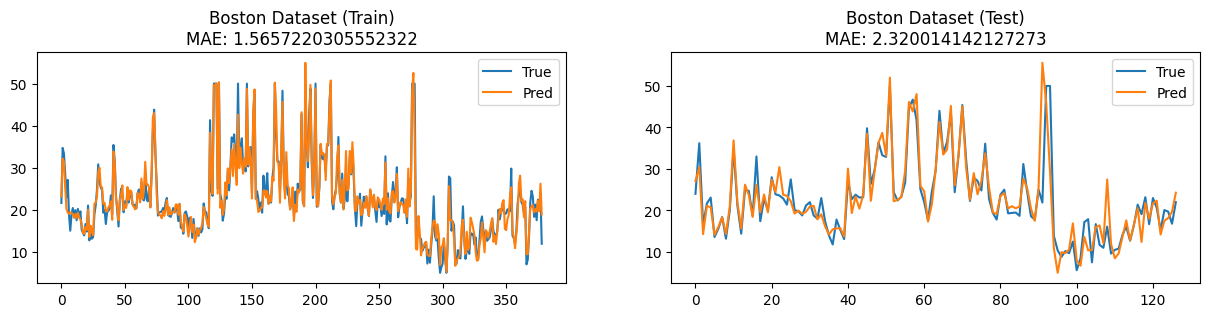

In [11]:

pred_y = model(train_x)
pred_y = pred_y*(max_val_y-min_val_y)+(min_val_y)
orig_train_y = train_y*(max_val_y-min_val_y)+(min_val_y)
train_mae = (abs(pred_y-orig_train_y).mean()).data
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.title(f"Boston Dataset (Train)\nMAE: {train_mae}")
plt.plot(orig_train_y.data, label="True")
plt.plot(pred_y.data, label="Pred")
plt.legend()

pred_y = model(test_x)
pred_y = pred_y*(max_val_y-min_val_y)+(min_val_y)
test_mae = (abs(pred_y-test_y).mean()).data

plt.subplot(1, 2, 2)
plt.title(f"Boston Dataset (Test)\nMAE: {test_mae}")
plt.plot(test_y.data, label="True")
plt.plot(pred_y.data, label="Pred")
plt.legend()
plt.show()

## Mnist (Classifcation, Conv2d)

- Conv 연산의 속도에서 큰 차이를 보임 (약 100배)

In [1]:
import numpy as np
import src as my
from dataset import *
import tqdm
import matplotlib.pyplot as plt

In [2]:
train_x, train_y, test_x, test_y = mnist()
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

rand_idx = np.random.choice(np.arange(60000), 60000, replace=False)
train_x = train_x[rand_idx, np.newaxis, ...].astype(np.float32())/255.
test_x = test_x[:, np.newaxis, ...].astype(np.float32())/255.

# One-hot encoding
train_y = np.eye(10)[train_y][rand_idx].astype(np.float32())
test_y = np.eye(10)[test_y].astype(np.float32())

# Wrap with Param object
train_x = my.Param(train_x[:6000])
train_y = my.Param(train_y[:6000])
test_x = my.Param(test_x[:1000])
test_y = my.Param(test_y[:1000])
train_x.shape, train_y.shape, test_x.shape, test_y.shape

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


((6000, 1, 28, 28), (6000, 10), (1000, 1, 28, 28), (1000, 10))

In [4]:

class Model(my.layers.Module):
    def __init__(self):
        self.l1 = my.layers.Conv2d(1, 16, 3, 1, 1)
        self.pool1 = my.layers.Conv2d(16, 16, 2, 2)
        self.l3 = my.layers.Conv2d(16, 16, 3, 1, 1)
        self.pool2 = my.layers.Conv2d(16, 16, 2, 2)
        self.l5 = my.layers.Conv2d(16, 16, 3, 1, 1)
        self.pool3 = my.layers.Conv2d(16, 16, 2, 2)
        self.activation = my.layers.ReLU()

        self.head = my.layers.Linear(16*9, 10)
        self.softmax = my.layers.Softmax()

    def forward(self,x):
        b, _, _, _ = x.shape
        out = self.l1(x)
        out = self.activation(out)
        out = self.pool1(out)

        out = self.l3(out)
        out = self.activation(out)
        out = self.pool2(out)

        out = self.l5(out)
        out = self.activation(out)
        out = self.pool3(out)

        out = out.reshape((b, -1))
        out = self.head(out)
        out = self.softmax(out)
        return out

model = Model()
optim = my.optimizers.Adam(model.parameters(), lr=1e-3)

def accuracy(pred, target):
    pred = np.argmax(pred, 1)
    target = np.argmax(target, 1)
    return (pred==target).mean()

def categorical_cross_entropy(y_true, y_pred):
    return -(y_true * my.log(y_pred)).mean()

batch_size = 16
train_acc = []
train_loss = []

it = tqdm.tqdm(range(0, train_x.shape[0], batch_size))
for idx in it:
    pred = model(train_x[idx: idx+batch_size])
    loss = categorical_cross_entropy(train_y[idx:idx+batch_size], pred)
    train_acc.append(accuracy(pred.data, train_y.data[idx:idx+batch_size]))
    train_loss.append(loss.data)
    loss.backward()
    optim.step()
    optim.zero_grad()
    it.set_description(desc=f"Train_losses:{train_loss[-1]:03f}/{np.mean(train_loss):03f}, Train_acc:{train_acc[-1]:03f}/{np.mean(train_acc):03f}")



Train_losses:0.137224/0.066796, Train_acc:0.750000/0.787333: 100%|██████████| 375/375 [03:32<00:00,  1.77it/s]


In [5]:

for p in model.parameters():
    p.requires_grad = False

test_acc = []
test_loss = []

it = tqdm.tqdm(range(0, test_x.shape[0], batch_size))
for idx in it:
    pred = model(test_x[idx: idx+batch_size])
    loss = categorical_cross_entropy(test_y[idx:idx+batch_size], pred)
    test_acc.append(accuracy(pred.data, test_y.data[idx:idx+batch_size]))
    test_loss.append(loss.data)
    it.set_description(desc=f"Test_losses:{test_loss[-1]:03f}/{np.mean(test_loss):03f}, Test_acc:{test_acc[-1]:03f}/{np.mean(test_acc):03f}")



Test_losses:0.015654/0.034398, Test_acc:1.000000/0.884921: 100%|██████████| 63/63 [00:14<00:00,  4.33it/s]


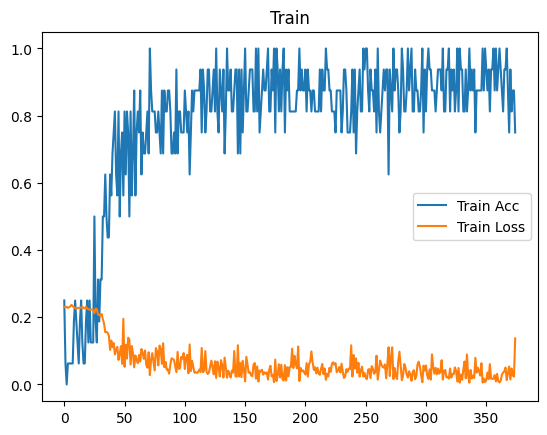

In [6]:

plt.title("Train")
plt.plot(train_acc, label="Train Acc")
plt.plot(train_loss, label="Train Loss")
plt.legend()
plt.show()

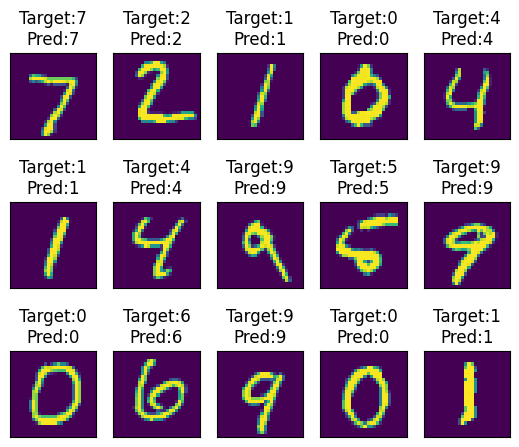

In [50]:
num_lines = 3
pred_per_line = 5
pred = model(test_x[:pred_per_line*num_lines])
plt.figure(figsize=(10, 4))
plt.subplots_adjust(left=0, right=.5, top=2, bottom=.2)
for i in range(num_lines):
    for j in range(pred_per_line):
        plt.subplot(pred_per_line, pred_per_line, i*pred_per_line+j+1)
        plt.title(f"Target:{np.argmax(test_y.data[i*pred_per_line+j])}\nPred:{np.argmax(pred.data[i*pred_per_line+j])}")
        plt.imshow(test_x.data[i*pred_per_line+j, 0])
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
plt.show()

# Set Inplace 연산 테스트

- Inplace 연산인 Set 로직은 연산 그래프(Computational Graph)의 구조를 망칠 가능성이 존재

- 'Pytorch에서는 이를 어떻게 방지하는가?'를 바탕으로 해결방법 생각

    - Pytorch는 연산과정에서 _version 변수를 두어 이런 과정을 보완

- Version 관리 방법

    1. 모든 노드는 생성시 _version 값을 0으로 가짐
    
    2. inplace 연산시 _version의 값을 증가시키고 ctx에 _version 정보를 기록

    3. Backward 단계에서 각 노드별로 첫 연산 때의 _version 값과 현재 _version 값을 비교하여 다르다면 오류 발생

        - 만일 a*b (MulBackward) 이후 a에 Set Inplace 연산을 한 경우 첫연산(Mul)의 _version(=0)과 현재의 _version(=1)과 다르기에 오류가 남

In [1]:
import torch
import src as my

In [2]:

a= torch.tensor([1., 3., 5.], requires_grad=False)
x = torch.tensor([5., 4., 3.], requires_grad=True)
c = torch.tensor([5.], requires_grad=True)

a_ = a*3 # 인덱싱과정에서 발생하는 leaf tensor 오류를 피하기 위함 

y = a_*x # 이 과정에서 원래라면 x에는 값 [3, 9, 15] 가 Gradient로 흐르도록 설계 (Mul 연산이므로)

print(a._version, x._version, c._version, a_._version, y._version)
a_[2] = c  # Inplace Set 연산을 하게 되면서 a_[2]의 값이 변경됨 -> 이로인해 a_*x 의 역전파 과정에서 x에는 값 [3, 9, 5]가 Gradient로 흐르게 될 수 있음(값이 Copy 되지 않는 경우) 
# 이때 z의 requires_grad = True가됨
print(a._version, x._version, c._version, a_._version, y._version)
y.sum().backward()


0 0 0 0 0
0 0 0 1 0


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [3]], which is output 0 of struct torch::autograd::CopySlices, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [3]:

a= my.Param([1., 3., 5.], requires_grad=False)
x = my.Param([5., 4., 3.], requires_grad=True)
c = my.Param([5.], requires_grad=True)

a_ = a*3 # 인덱싱과정에서 발생하는 leaf tensor 오류를 피하기 위함 

y = a_*x # 이 과정에서 원래라면 x에는 값 [3, 9, 15] 가 Gradient로 흐르도록 설계 (Mul 연산이므로)

print(a._version, x._version, c._version, a_._version, y._version)
a_[2] = c  # Inplace Set 연산을 하게 되면서 a_[2]의 값이 변경됨 -> 이로인해 a_*x 의 역전파 과정에서 x에는 값 [3, 9, 5]가 Gradient로 흐르게 될 수 있음(값이 Copy 되지 않는 경우) 
# 이때 z의 requires_grad = True가됨
print(a._version, x._version, c._version, a_._version, y._version)
y.sum().backward()


0 0 0 0 0
0 0 0 1 0


RuntimeError: One of the differentiated Node appears to have been modified in-place since being used for gradient computation.